# Using K-Means Clustering for Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler #Install sklearn
from kneed import KneeLocator #Install #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/anpi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Importing the data

Using R, we first computed the annual average spend of each customer.

![average_annual](../images/average annual spend.png)

From the scatter plot, we identified some outliers and decided to remove them so as to not affect the clustering. The outliers are customers with annual average spend of more than 10000 Ringgit.

We then used the idea of RFM modelling and generated the data used for K-Means clustering.

Data summary:

1) **Recency**: The number of weeks since the customer's last transaction. The reference date is taken to be one week after the last transaction among all the transactions.

2) **Monetary**: The annual average spend of the customer.

3) **Frequency**: The annual average number of transactions of the customer.

In [68]:
rfm = pd.read_csv('../cleaned_data/rfm.csv')

In [69]:
rfm.head()

,Unnamed: 0,pid,Recency,Monetary,Frequency
0,1,101011101,15,1300.466667,36.333333
1,2,101016101,8,629.200000,23.666667
2,3,101019101,1,2436.933333,51.000000
3,4,101024101,1,1995.900000,51.000000
4,5,105009103,1,1567.566667,52.000000


We remove the index column and generate a new data frame with only the Recency and Monetary values.

In [70]:
rfm = rfm.drop(columns = ['Unnamed: 0'])
rfm_data = rfm.drop(columns = ['pid'])

In [71]:
rfm_data.describe()

,Recency,Monetary,Frequency
count,3233.000000,3233.000000,3233.000000
mean,224.311475,1295.266161,25.346531
std,331.880236,1178.983072,17.292691
min,1.000000,3.266667,0.333333
25%,1.000000,362.766667,8.333333
50%,8.000000,1013.666667,25.333333
75%,393.000000,1885.966667,42.000000
max,1086.000000,9086.133333,52.000000


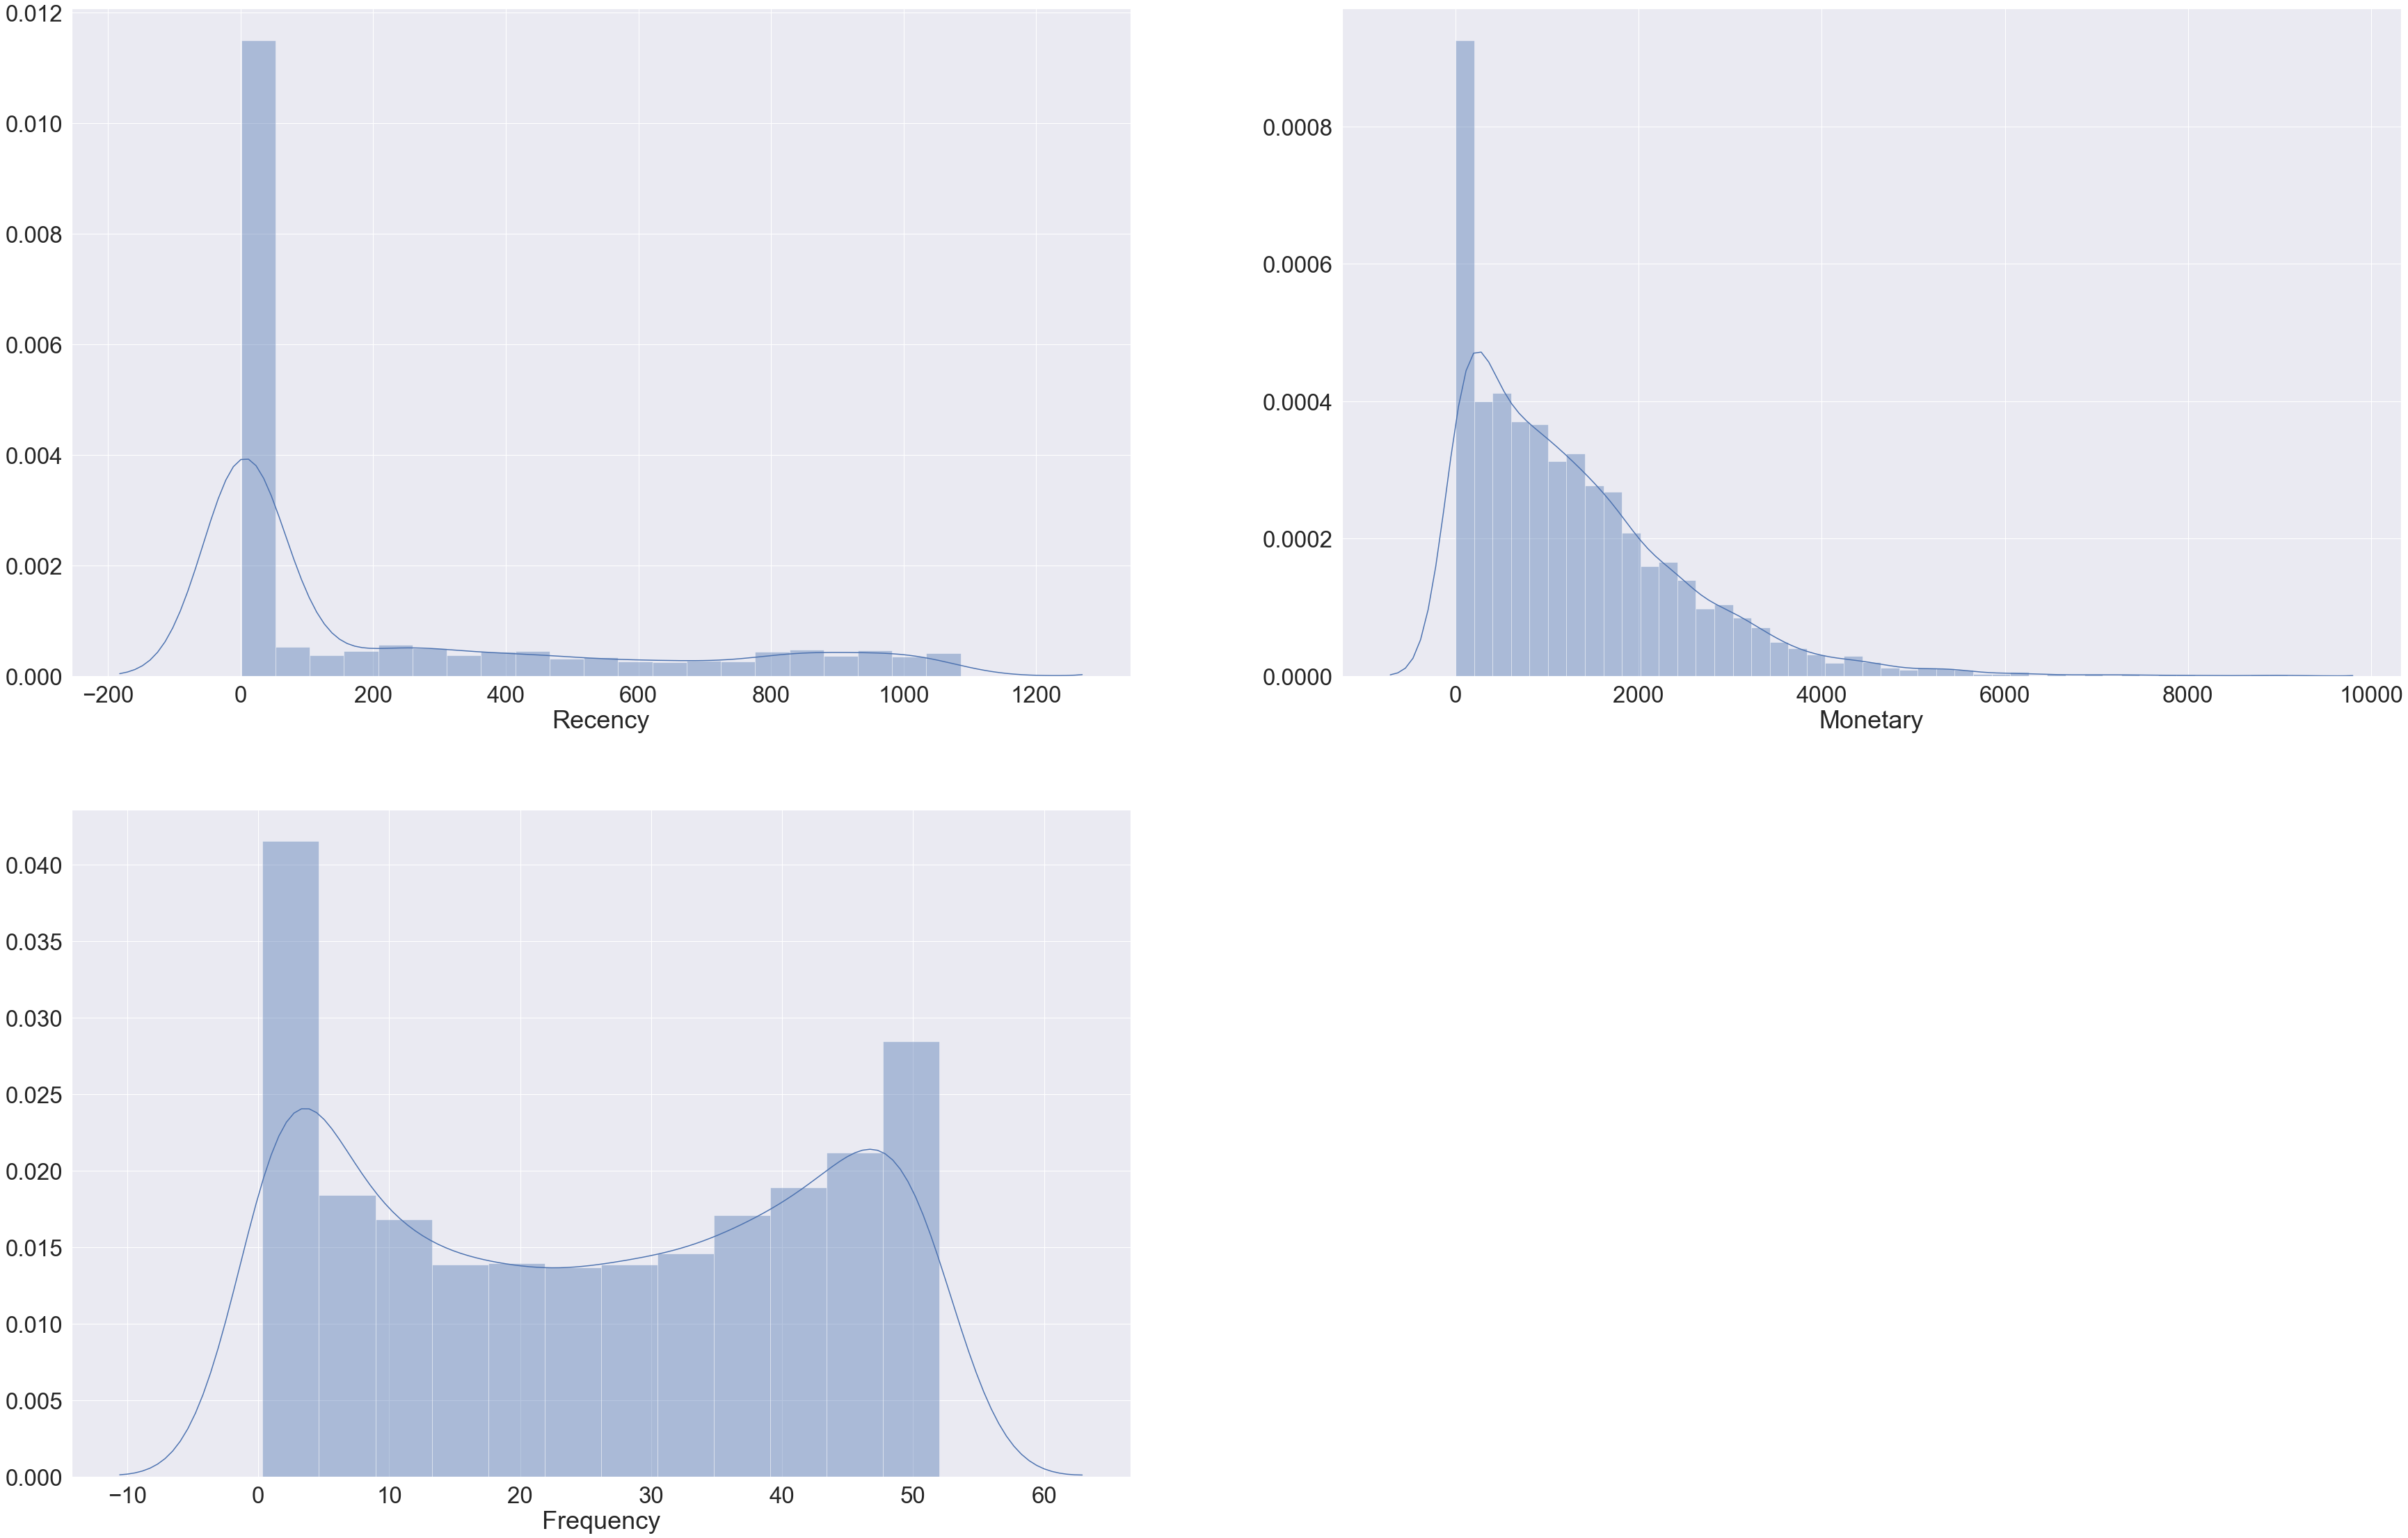

In [72]:
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(len(rfm_data.columns)):
    plt.subplot(3,2,i+1)
    freshplot = sns.distplot(rfm_data.iloc[:,i])

From the plot and the data summary, it is observed that most of the customers have spent at the supermarket recently. Most of the customers have average spend of less than 2000 Ringgit annually. As for annual average number of visits to the supermarket, it is more uniformly distributed, although there is a relatively large number of customers who visit the supermarket less frequently.

In [73]:
rfmarray = rfm_data.to_numpy()
#fmarray = fm.to_numpy()

In [74]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfmarray)#Scaling inputs if required

## Choosing the appropriate number of clusters

### Elbow method with Total WCSS vs Number of Clusters

In [75]:
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(rfmarray)
    wcss.append(kmeans.inertia_)

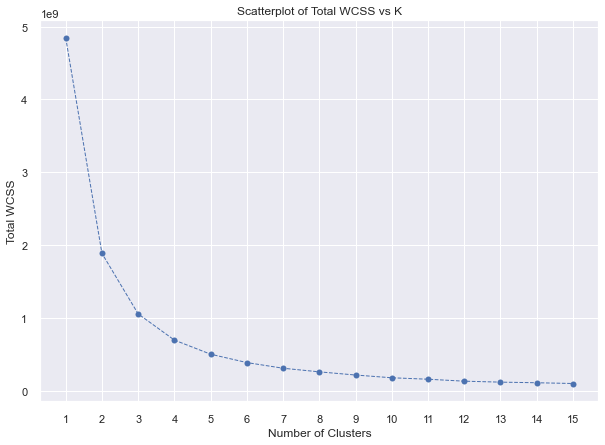

In [76]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [77]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

#To locate the elbow point of the curve using kneed package

4

### K-means using RFM data - 4 clusters

In [78]:
kmeans4 = KMeans(init="random",n_clusters = 4 , n_init = 10, max_iter = 300, random_state = 42)
kmeans4.fit(rfmarray)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [79]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Recency", 1: "Monetary", 2: "Frequency"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [80]:
Clustercenters4

,Recency,Monetary,Frequency
Clusters,,,
0,67.206336,1264.247603,32.539384
1,496.560440,290.990424,8.270277
2,11.282759,4668.843678,44.450575
3,19.269350,2574.690660,41.730134


In [81]:
model_4 = rfm_data.copy()
model_4['Clusters'] = pd.DataFrame(clustergroups4) #Combining the column of clusters to the original dataframe

In [82]:
model_4.head()

,Recency,Monetary,Frequency,Clusters
0,15,1300.466667,36.333333,0
1,8,629.200000,23.666667,1
2,1,2436.933333,51.000000,3
3,1,1995.900000,51.000000,3
4,1,1567.566667,52.000000,0


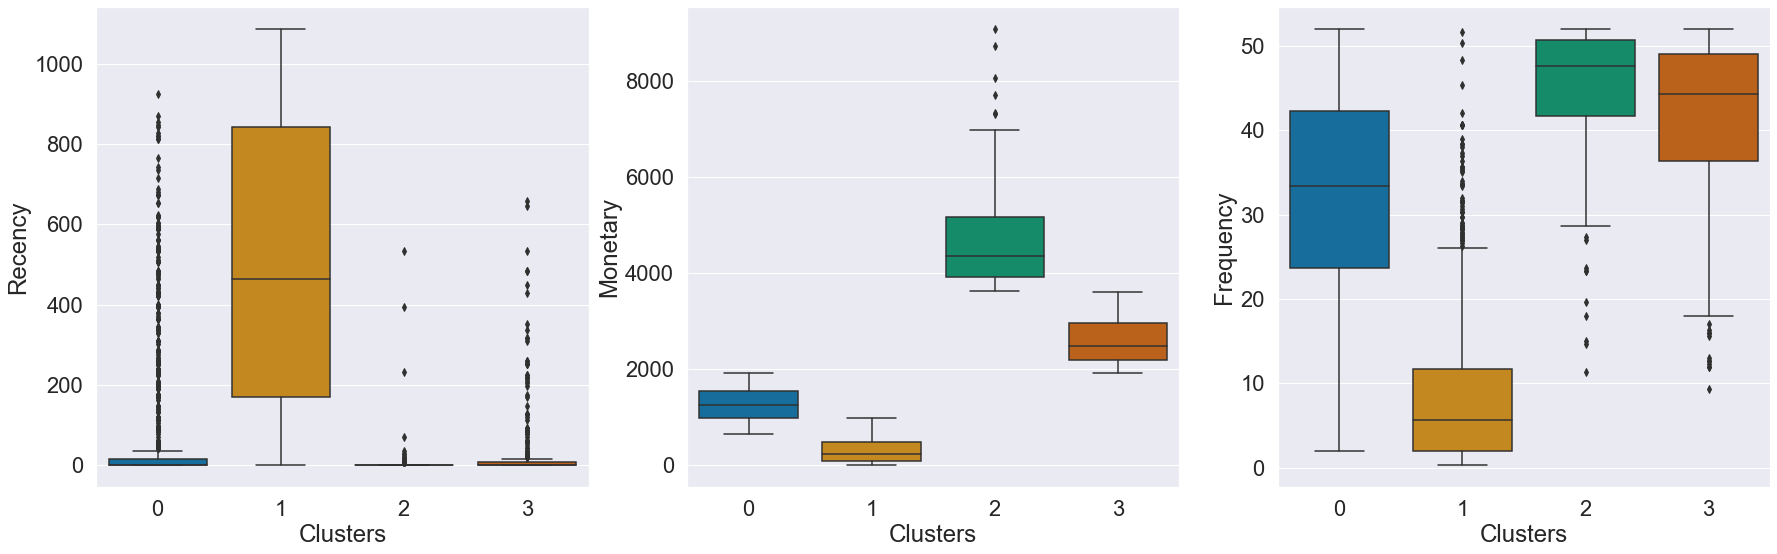

In [83]:
#Boxplot for each cluster and feature
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(len(model_4.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=model_4.columns[i], x='Clusters', data=model_4, palette="colorblind")

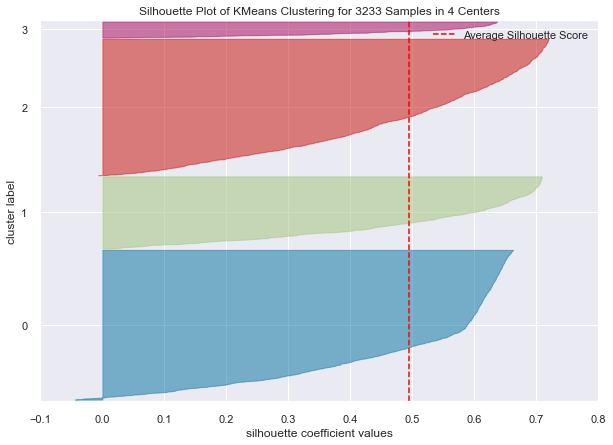

For n_clusters = 4 The average silhouette_score is: 0.4951807875617772


In [84]:
model = KMeans(4, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, rfmarray, colors='yellowbrick')
print("For n_clusters = 4 The average silhouette_score is: " + str(silhouette_score(rfmarray, model.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 4

### K-means for Recency vs Monetary - 5 clusters

In [85]:
kmeans5 = KMeans(init="random",n_clusters = 5 , n_init = 10, max_iter = 300, random_state = 42)
kmeans5.fit(rfmarray)
clustergroups5 = kmeans5.labels_ #The cluster number for each row

In [86]:
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_) #Dataframe of cluster centers
Clustercenters5.rename(columns={0: "Recency", 1: "Monetary", 2: "Frequency"},inplace=True)
Clustercenters5.index.name = "Clusters"

In [87]:
model_5 = rfm_data.copy()
model_5['Clusters'] = pd.DataFrame(clustergroups5) #Combining the column of clusters to the original dataframe

In [88]:
model_5.head()

,Recency,Monetary,Frequency,Clusters
0,15,1300.466667,36.333333,1
1,8,629.200000,23.666667,3
2,1,2436.933333,51.000000,4
3,1,1995.900000,51.000000,1
4,1,1567.566667,52.000000,1


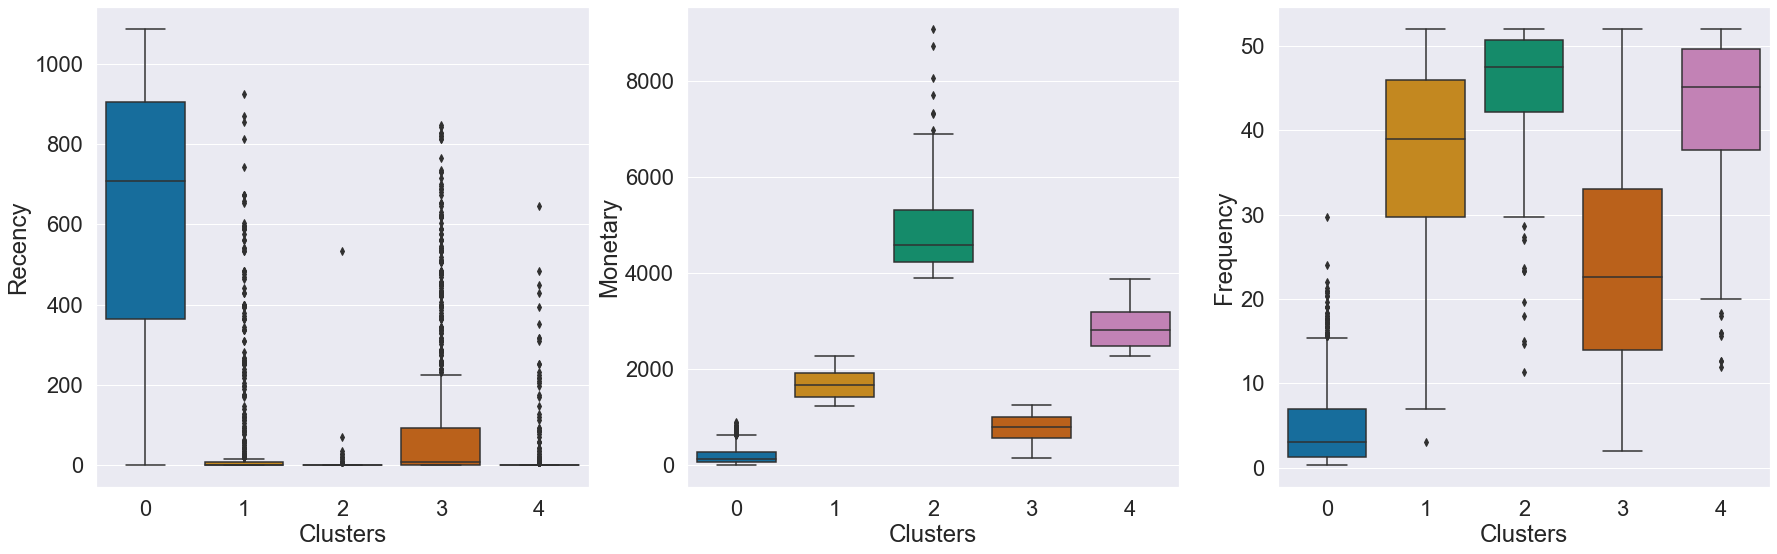

In [89]:
#Boxplot for each cluster and feature
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(len(model_5.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=model_5.columns[i], x='Clusters', data=model_5, palette="colorblind")

In [66]:
#sns.scatterplot(x='Monetary', y='Recency', hue='Clusters', data = model_5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.show()

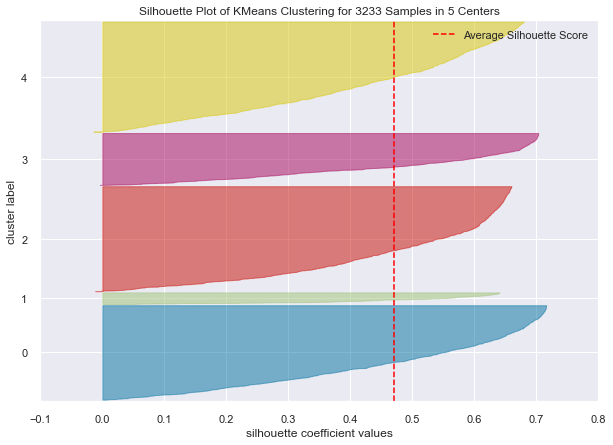

For n_clusters = 5 The average silhouette_score is: 0.4712288825484517


In [90]:
model = KMeans(5, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, rfmarray, colors='yellowbrick')
print("For n_clusters = 5 The average silhouette_score is: " + str(silhouette_score(rfmarray, model.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 5

With a higher silhouette score, it might be better to segement the customers into 4 clusters based on the RFM attributes.

## Visualisation of the clustering

### Recency VS Monetary

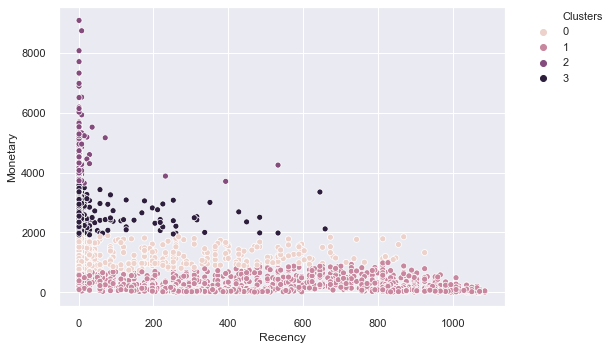

In [91]:
sns.scatterplot(x='Recency', y='Monetary', hue='Clusters', data = model_4)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Frequency VS Monetary

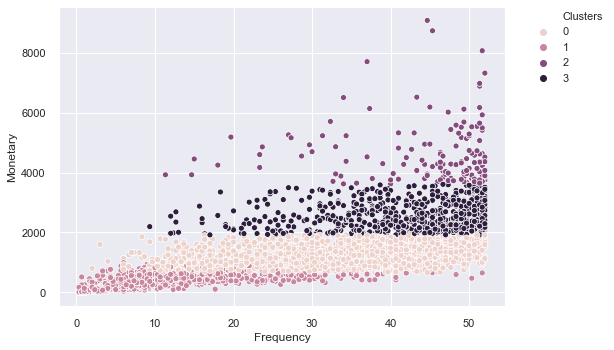

In [92]:
sns.scatterplot(x='Frequency', y='Monetary', hue='Clusters', data = model_4)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Recency VS Frequency

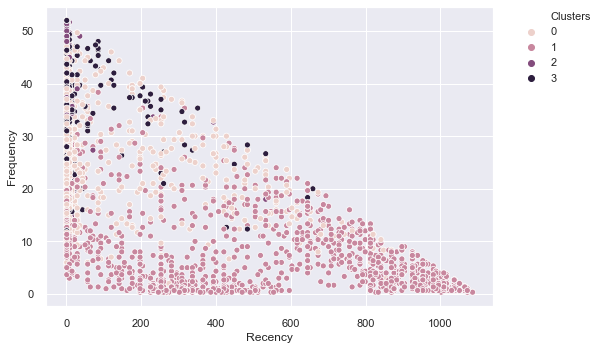

In [93]:
sns.scatterplot(x='Recency', y='Frequency', hue='Clusters', data = model_4)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

This plot does not show clear clustering of the customers.

### Insights

From the scatter plots, we could derive the following customer profiles:

1) **Cluster 0**: This group of customers visit the supermarket least frequently and spend less (<1000) annually at the supermarket. Their last transactions took place over a very large duration of time.

2) **Cluster 1**: This group of customers visit the supermarkt more frequently and spend more than cluster 0 customers. However, their average annual spend is still less than 2000 Ringgit. Their last transaction took place over a large duration of time as well.

3) **Cluster 2**: This group of customers visit the supermarket more frequently than cluster 1 and spend between 2000 to 4000 Ringgit on average per year. Most of them have visited the supermarket recently.

4) **Cluster 3**: This group of customers visit the supermarket most frequently and spend the most (>4000 Ringgit) on average per year. Their most recent transactions are also concentrated around 1, which is the last week in the dataset.

Therefore, we could see that K-Means clustering combined with RFM modelling can help us give suggestions on which segment outreach the supermarket should prioritise. Different campaigns should also be given to different customer profiles.